# COVID-19

Interpretable Machine Learning course homework no. 2\
Tymoteusz Makowski

[Data source](https://docs.google.com/spreadsheets/d/1itaohdPiAeniCXNlntNztZ_oRvjh0HsGuJXUJWET008/)

## Imports

In [1]:
import pandas as pd
import numpy as np
import shap

from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from pyBreakDown.explainer import Explainer
from pyBreakDown.explanation import Explanation

In [3]:
cols = [
    "age",
    "sex",
    "country",
    "date_onset_symptoms",
    "date_admission_hospital",
    "date_confirmation",
    "symptoms",
    "chronic_disease",
    "outcome",
    "date_death_or_discharge"
]

data_raw = pd.read_csv("data/covid19.csv", usecols=cols)
print(data_raw.shape)
data_raw.head(3)

(21241, 10)


,age,sex,country,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,chronic_disease,outcome,date_death_or_discharge
0,30,male,China,18.01.2020,20.01.2020,22.01.2020,NaN,NaN,NaN,NaN
1,47,male,China,10.01.2020,21.01.2020,23.01.2020,NaN,NaN,NaN,NaN
2,49,male,China,15.01.2020,20.01.2020,23.01.2020,NaN,NaN,NaN,NaN


# Data preparation

### Symptoms

In [4]:
symptoms_list = []
for symp in data_raw.symptoms:
    if not pd.isna(symp):
        symptoms_list += [s.strip() for s in symp.split(",")]
        
symptoms_raw = pd.Series(symptoms_list).map(lambda x: x.lower())
symptoms_counts = symptoms_raw.reset_index().rename(columns={0: "symptom"}).groupby("symptom").count().reset_index().rename(columns={"index": "cnt"})
signif_counts = symptoms_counts.query("cnt > 4").reset_index(drop=True)

In [5]:
# Greater than 4 cases.
signif_symptoms_list = [
    "asymptomatic", "bone pain", "chest tightness", "chills", "cough", "coughing", "diarrhea", "discomfort", "dyspnea",
    "fatigue", "fever", "headache", "joint pain", "malaise", "myalgia", "nausea", "phlegm", "pneumonia", "pneumonitis",
    "runny nose", "shortness of breath", "sneezing", "sore throat", "sputum"
]

signif_symptoms = dict(
    [("MuscleSoreness", "soreness"), ("Weakness", "weak")] +\
    [(s.title().replace(" ", ""), s) for s in signif_symptoms_list]
)

###  Utility functions

In [6]:
def map_outcome(x):
    if pd.isna(x):
        return 0
    return int(x in ["died", "death"])


def map_age(x):
    try:
        x = float(x)
    except ValueError:
        if x[0] == x[-2] and x[1] == "0" and x[-1] == "9":
            x = int(x[:2])
        else:
            return np.nan
        
    return x // 10


def map_sex(x):
    if pd.isna(x):
        return np.nan
    
    return int(x == "male")
    
    
def days_diff(x, y, date_format="%d.%m.%Y"):
    try:
        x = dt.strptime(x, date_format)
        y = dt.strptime(y, date_format)
    except:
        return np.nan
    
    return (x - y).days

###  Converting data

In [7]:
data = pd.DataFrame(columns=[
    "HasDied",
    "Age",
    "Sex",
    "Country",
    "DaysInHospital",
    "DaysBeforeHospitalization",
    "DaysBeforeConfirmation"
])

country_dict = dict([(c, np.nan if pd.isna(c) else i) for i, c in enumerate(data_raw.country.unique())])

for i in range(data_raw.shape[0]):
    d = {}
    row = data_raw.loc[i, :]
    
    d["HasDied"] = map_outcome(row.outcome)
    d["Age"] = map_age(row.age) # Age i: corresponds to (10 * i, 10 * (i + 1) - 1)
    d["Sex"] = map_sex(row.sex) # 1 - man, 0 - woman
    d["Country"] = country_dict.get(row.country)
    d["DaysInHospital"] = days_diff(row.date_death_or_discharge, row.date_admission_hospital)
    d["DaysBeforeHospitalization"] = days_diff(row.date_admission_hospital, row.date_onset_symptoms)
    d["DaysBeforeConfirmation"] = days_diff(row.date_confirmation, row.date_onset_symptoms)
    d["DaysAfterConfirmation"] = days_diff(row.date_death_or_discharge, row.date_confirmation) # Days as confirmend affected
    
    # Symptoms
    for k, v in signif_symptoms.items():
        d[k] = np.nan if pd.isna(row.symptoms) else int(row.symptoms.find(v) != -1)
    
    data = data.append(d, ignore_index=True)

data.head(5)

,HasDied,Age,Sex,Country,DaysInHospital,DaysBeforeHospitalization,DaysBeforeConfirmation,Asymptomatic,BonePain,ChestTightness,...,Nausea,Phlegm,Pneumonia,Pneumonitis,RunnyNose,ShortnessOfBreath,Sneezing,SoreThroat,Sputum,Weakness
0,0.0,3.0,1.0,0.0,NaN,2.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,4.0,1.0,0.0,NaN,11.0,13.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,4.0,1.0,0.0,NaN,5.0,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,4.0,0.0,0.0,NaN,3.0,6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,5.0,0.0,0.0,NaN,11.0,13.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Splitting the data

In [20]:
feature_names = data.columns[1:]

# Only records with outcome value not missing.
has_outcome = ~data_raw.outcome.isna()
X_train, X_test, y_train, y_test = train_test_split(
    np.array(data[has_outcome].dropna(thresh=3).iloc[:, 1:]),
    np.array(data[has_outcome].dropna(thresh=3).iloc[:, 0]),
    test_size=0.3,
    random_state=58
)

# Modelling

In [10]:
model = CatBoostClassifier(random_seed=58)
model.fit(X_train, y_train, verbose=False)

In [11]:
# The classes are extremely unbalanced, hence its a good thing if the classfier predicted literally anything to be in class 1.
pred_labels = model.predict(X_test)
(pred_labels == 1).sum(), (y_test == 1).sum()

(4, 3)

In [12]:
# Accuracy
(pred_labels == y_test).sum() / len(y_test)

0.9791666666666666

In [13]:
# F1 score
f1_score(pred_labels, y_test)

0.8571428571428571

# Explaining an observation

### Selecting an observation (true positive)

In [16]:
np.where(np.logical_and(pred_labels == 1, y_test == 1))

(array([27, 31, 43], dtype=int64),)

In [103]:
obs = X_test[43, :]
pd.DataFrame(obs, feature_names, columns=["Value"])

,Value
Age,7.0
Sex,1.0
Country,20.0
DaysInHospital,NaN
DaysBeforeHospitalization,NaN
DaysBeforeConfirmation,NaN
Asymptomatic,NaN
BonePain,NaN
ChestTightness,NaN
Chills,NaN


#### Model prediction for the observation

In [101]:
# Model predicts 1 - death of the patient.
model.predict(obs)

1.0

#### Model explaination for the observation

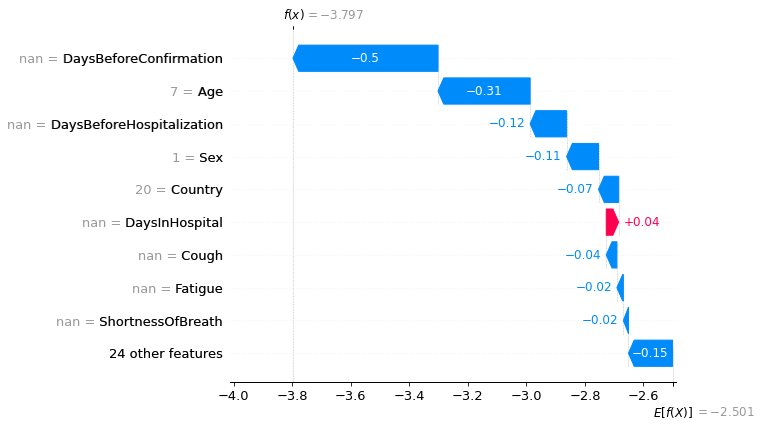

In [42]:
shap_explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = shap_explainer.shap_values(X_train)

shap.waterfall_plot(shap_explainer.expected_value, shap_values[43, :], feature_names=feature_names, features=X_test[43,:])

## Task 4

### Observation 1

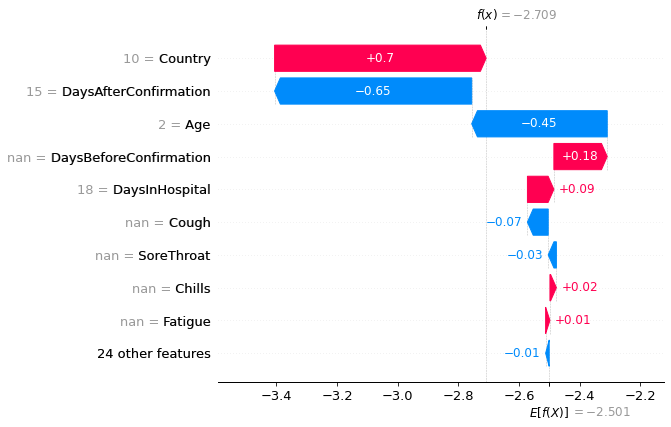

In [44]:
shap.waterfall_plot(shap_explainer.expected_value, shap_values[0, :], feature_names=feature_names, features=X_test[0,:])

### Observation 2

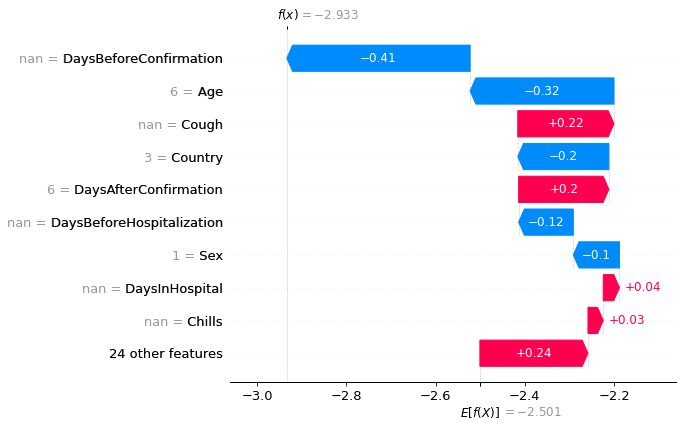

In [46]:
shap.waterfall_plot(shap_explainer.expected_value, shap_values[23, :], feature_names=feature_names, features=X_test[23,:])

### Comment
For the first observation the `Country` was a huge factor - possibly very few cases originated from that country and none resulted in death. Comming up is the `DaysAfterConfirmation` which was heavily shifted the prediction towards death.

For the second observation the `DaysBeforeConfirmation` is the most important variable. The second most importand variable is `Age` which makes sense since the `Age = 6` maps to `60-69` which is known to have negative impact on survivability.

## Task 5

The variable `DaysAfterConfirmation` has positive impact for the Observation 2 and negative impact for the Observation 1. That result is dependent on the value of the variable. In the second observation the value is lower and therefore improves survival odds according to the model. In the first one it is a higher value meaning a longer sickness period which in turn has negative impact on model's prediction.

## Task 6

### Model training

In [61]:
# Mapping missing values to -9999
X_train2 = np.copy(X_train)
X_train2[np.isnan(X_train2)] = -9999

X_test2 = np.copy(X_test)
X_test2[np.isnan(X_test2)] = -9999

In [62]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train2, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [63]:
pred_labels2 = rf_model.predict(X_test2)

### Finding differing observations

In [66]:
shap_explainer2 = shap.TreeExplainer(rf_model, feature_perturbation="tree_path_dependent")
shap_values2 = shap_explainer2.shap_values(X_train2)

In [97]:
def compare_attribution(i):
    shap.waterfall_plot(shap_explainer.expected_value, shap_values[i, :], feature_names=feature_names, features=X_test[i,:])
    shap.waterfall_plot(shap_explainer2.expected_value[1], shap_values2[1][i, :], feature_names=feature_names, features=X_test2[i,:])

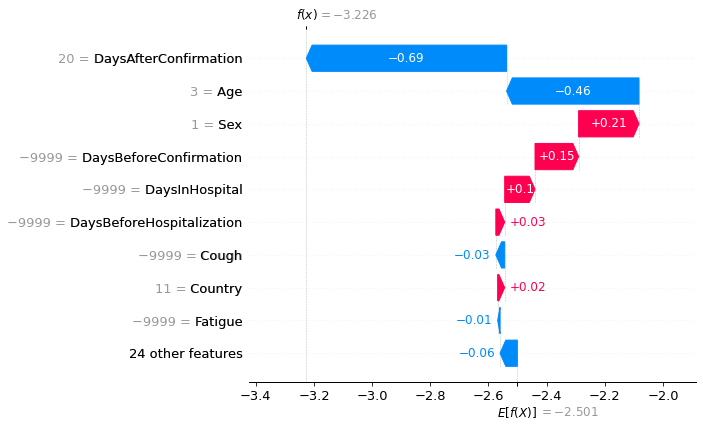

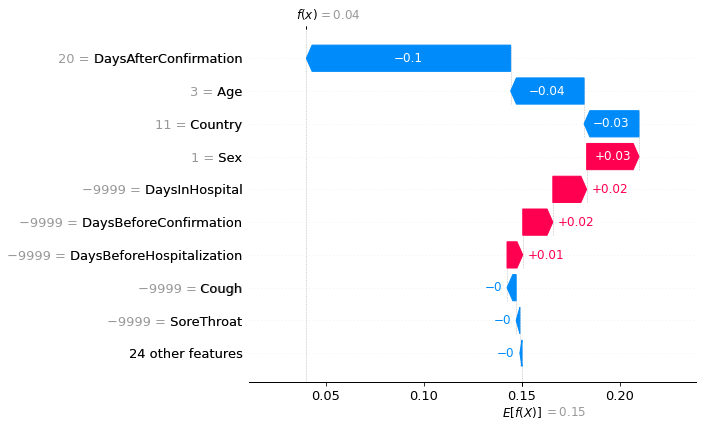

In [98]:
compare_attribution(3)

### Comment
As we can se the found observation has different attribution for `Country` variable. The top plot (Catboost) states that the `Country` for this observation has positive impact on survival chance whereas the second plot (Random Forest) shows that this variable has negative impact on survivability.